# 3. Download Dataset

**Quick overview of the 3W dataset structure**

This notebook provides instructions to download the 3W Dataset, an overview on the structure and organization of the dataset, and a quick data analysis utilizing the dataset features of the **3WToolkit v2.0.0**.

## 📋 Table of Contents

1. [Prerequisites](#Prerequisites)
2. [Downloading the dataset](#Downloading)
3. [The 3W Dataset in depth](#The-3W-Dataset)
    1. [Dataset organization](#Dataset-organization)
    2. [Dataset format](#Dataset-format)
    3. [Dataset labeling](#Labeling-and-fault-transients)
    4. [Dataset cleaning](#Data-cleanup)
4. [Next Steps](#Next-Steps)
---


## Prerequisites

Before downloading the 3WToolkit, ensure you have the following:

### System Requirements
- **Storage**: At least 4GB free space for the dataset package and its deflated version.

### That's all!
- All other dependencies are included in the toolkit!

## Downloading

To download the latest version of the **3W Dataset**, all we need to do is instantiate `ParquetDataset` using a `ParquetDatasetConfig` pointing to the desired directory through `path`. Leaving all options on default will simply download and extract the latest 3W from our standard repository, [figshare](https://figshare.com/).

In [1]:
from ThreeWToolkit.dataset import ParquetDataset, ParquetDatasetConfig

config = ParquetDatasetConfig(path="./dataset")
dataset = ParquetDataset(config)

[ParquetDataset] Dataset found at ./dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!


If the dataset is already downloaded and extracted, instantiating a ParquetDataset again, in the same location will simply execute a consistency check, to ensure you have the correct data. You can override this behavior using the flag `force_download`.

In [2]:
config = ParquetDatasetConfig(
    path="./dataset",
    #force_download=True,
)
dataset = ParquetDataset(config)
print(f"We got {len(dataset)} events!")

[ParquetDataset] Dataset found at ./dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!
We got 2228 events!


## The 3W Dataset

### Dataset organization

#### Event classes
The 3W Dataset is a collection of annotated events, belonging in 10 different classes:

0. Normal Operation
1. Abrupt Increase of BSW
2. Spurious Closure of DHSV
3. Severe Slugging
4. Flow Instability
5. Rapid Productivity Loss
6. Quick Restriction in PCK
7. Scaling in PCK
8. Hydrate in Production Line
9. Hydrate in Service Line

Each event is stored inside a directory corresponding to its code, that is, all *Normal operation* events are in `0/`, all *Abrupt Increase of BSW* events are in `1/`, and so on.

It might be that we are only interested in evaluating our models against certain event classes.
We can apply filters to the dataset so that only the events belonging to a class of interest are included.

Say that we are only interested in *Normal operation* (0) and *Quick Restriction in PCK* (6). We may instantiate our dataset class using the `target_class` option, selecting only events belonging to classes 0 and 6:

In [3]:
config = ParquetDatasetConfig(
    path="./dataset",
    target_class=[0, 6] # pick the class numbers as needed.
)
dataset = ParquetDataset(config)
print(f"We got {len(dataset)} events!")

[ParquetDataset] Dataset found at ./dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!
We got 815 events!


A you may have noticed, leaving `target_class` in its default state results in events of all classes being loaded.

#### Event types

Beyond the different event classes, the 3W dataset possesses 3 kinds of events. These are
- `REAL` events, prefixed by `WELL-...`, containing real data, as captured by the sensors.
- `SIMULATED` events, prefixed by `SIMULATED_...`, containing event data from the well simulator software.
- `DRAWN` events, prefixed by `DRAWN_`, which are "templates", created by experts, detailing the ordinary behaviour of a particular fault.

Once more, we may be interested in selecting (or excluding) some event kinds from our experiment.
To do this we can instantiate our dataset using the `event_type` field inside the configuration.
(Leaving the field in its default state defaults to loading all event kinds.)

The `event_type` field takes a list of enumerated constants, as follows:

In [4]:
from ThreeWToolkit.core.enums import EventPrefixEnum as EventPrefix

config = ParquetDatasetConfig(
    path="./dataset",
    event_type=[EventPrefix.REAL, EventPrefix.SIMULATED] # Rejecting DRAWN instances
)
dataset = ParquetDataset(config)
print(f"We got {len(dataset)} events!")

[ParquetDataset] Dataset found at ./dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!
We got 2208 events!


We may, of course, combine the different filters. To load only `REAL` events in classes `1`, `2` and `3`, we can do

In [5]:
config = ParquetDatasetConfig(
    path="./dataset",
    target_class=[1, 2, 3],
    event_type=[EventPrefix.REAL,] # Rejecting SIMULATED and DRAWN instances
)
dataset = ParquetDataset(config)
print(f"We got {len(dataset)} events!")

[ParquetDataset] Dataset found at ./dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!
We got 58 events!


## Dataset format

Each event is an annotated recording of 27 variables regarding the well state, such as operating parameters, measured temperature and pressure along different points and more across time. The operating state of the well, as annotated by the experts, sits in the column `"class"` of the event.

Our `ParquetDataset` output consists of a dictionary, where the sensor data is in the `"signal"` key, the annotations are in the `"label"` key, and some extra metadata is also made available, such as the event name.

To get a single event, we can simply query our dataset instance with an appropriate index:

In [70]:
config = ParquetDatasetConfig(
    path="./dataset",
    clean_data=False, # Let's use the raw values for now.
)
dataset = ParquetDataset(config)
sample = dataset[1651]

print(sample.keys())

[ParquetDataset] Dataset found at ./dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!
dict_keys(['signal', 'label', 'file_name'])


Here we can check the values of the variables, for each timestamp in our event.

In [71]:
sample["signal"]

,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,...,P-PDG,PT-P,P-TPT,QBS,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT,state
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-26 13:51:08,53.0,51.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,23567330.0,NaN,11333640.0,NaN,0.836380,52.69722,NaN,79.72964,74.25685,<NA>
2018-04-26 13:51:09,53.0,51.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,23567520.0,NaN,11335380.0,NaN,0.856679,52.70154,NaN,79.72964,74.25764,<NA>
2018-04-26 13:51:10,53.0,51.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,23567700.0,NaN,11337110.0,NaN,0.876978,52.70586,NaN,79.72965,74.25845,<NA>
2018-04-26 13:51:11,53.0,51.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,23567880.0,NaN,11338850.0,NaN,0.897277,52.71019,NaN,79.72966,74.25924,<NA>
2018-04-26 13:51:12,53.0,51.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,23568070.0,NaN,11340590.0,NaN,0.917577,52.71451,NaN,79.72967,74.26004,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-26 15:44:16,53.0,35.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,24660500.0,NaN,11091050.0,NaN,1.766009,50.32685,NaN,79.32979,16.99739,0
2018-04-26 15:44:17,53.0,35.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,24660460.0,NaN,11091230.0,NaN,1.736612,50.32632,NaN,79.32971,16.99959,0
2018-04-26 15:44:18,53.0,35.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,24660420.0,NaN,11091420.0,NaN,1.707216,50.32579,NaN,79.32964,17.00179,0


In [72]:
sample["label"]

,class
timestamp,
2018-04-26 13:51:08,<NA>
2018-04-26 13:51:09,<NA>
2018-04-26 13:51:10,<NA>
2018-04-26 13:51:11,<NA>
2018-04-26 13:51:12,<NA>
...,...
2018-04-26 15:44:16,5
2018-04-26 15:44:17,5
2018-04-26 15:44:18,5


In [73]:
str(sample["file_name"])

'5/WELL-00016_20180426135108.parquet'

### Labeling and fault transients

Usually, the event recordings begin some time *before* the fault occurs. This means that for most events in the dataset, the first few datapoints are labeled as *Normal Operation*; that's why we see timestamps with label `0` on the example above.

Furthermore, for some event classes, the fault onset may not be a sudden change in operation; this means that during the fault development, the well may be in an intermediate state between normal operation and the eventual steady-state mode.

When this happens, we say that the fault is in a *transient* state, and this is reflected in the annotations as `10X`, where `X` is the code for the eventual fault.

An example of this happening with this instance is illustrated below:

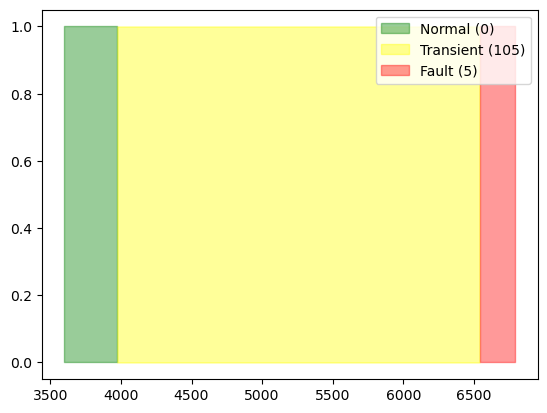

In [74]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,)
t = np.arange(len(sample["label"]))
ones = np.ones_like(t)
lab = sample["label"].values[:, 0]

ax.fill_between(t, 1, 0, where=(lab == 0),   color=("green", 0.4), label="Normal (0)")
ax.fill_between(t, 1, 0, where=(lab == 105), color=("yellow", 0.4), label="Transient (105)")
ax.fill_between(t, 1, 0, where=(lab == 5),   color=("red", 0.4), label="Fault (5)")
plt.legend(loc="upper right");

An easy way to map the labels `10X` to `X`, if needed, is to apply a modulus operation, $y = y \mod 100$ to the labels.

### Data cleanup

We are almost ready to use the 3W dataset, but we should proceed with care!

You may have noticed that the dataframe shown has a lot of *missing data*.
In fact, the 3W dataset, consisting of many real-world recordings of operating wells, suffers from the same challenges as the crews operating them do.

The communication between sensors and the platforms is unreliable, meaning that in the 3W dataset, we may observe phenomena such as
- missing sensors,
- frozen sensors,
- out-of-scale measurements,

all of which will interfere with our data analysis and data-driven models.

Seeing as data cleanup is both a needed and a common operation, we provide a sensible default cleanup routine, that performs
- removal of wrong readings
- removal of unused tags
- rescaling and centering of variables (to zero-mean unit-variance)
- imputation of missing values to zero (after the mean is translated to zero)

is available to our dataset class.

To use this cleaned version of the dataset, all we need to do is use the `clean_data` flag in our config:

In [75]:
config = ParquetDatasetConfig(
    path="./dataset",
    clean_data=True, # Let's use the cleaned up version!
)
dataset = ParquetDataset(config)
sample = dataset[0]

[ParquetDataset] Dataset found at ./dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!


In [76]:
sample["signal"]

,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,...,P-JUS-CKGL,P-JUS-CKP,P-MON-CKP,P-PDG,P-TPT,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-02-01 01:02:07,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202593,0.0,-0.549673,0.0,-0.663171,-0.846093,0.808054,0.0,0.0,0.726246
2017-02-01 01:02:08,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202593,0.0,-0.547936,0.0,-0.663171,-0.846093,0.807721,0.0,0.0,0.726246
2017-02-01 01:02:09,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202593,0.0,-0.546201,0.0,-0.663171,-0.846093,0.807388,0.0,0.0,0.726246
2017-02-01 01:02:10,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202593,0.0,-0.544464,0.0,-0.663171,-0.846093,0.807054,0.0,0.0,0.726246
2017-02-01 01:02:11,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202593,0.0,-0.542728,0.0,-0.663171,-0.846093,0.806720,0.0,0.0,0.726246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-01 06:59:56,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202241,0.0,-0.588429,0.0,-0.673336,-0.846093,0.744777,0.0,0.0,0.725172
2017-02-01 06:59:57,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202241,0.0,-0.586665,0.0,-0.673336,-0.846093,0.745509,0.0,0.0,0.725169
2017-02-01 06:59:58,0.0,0.0,0.867921,0.414652,-0.681653,-0.094347,-1.094009,0.312558,0.650525,-0.563169,...,-1.202241,0.0,-0.584901,0.0,-0.673336,-0.846093,0.746240,0.0,0.0,0.725165


If you're curious, for continuous variables we did the following procedure:
- we've defined, observing the spread of values in the dataset and the plausible values of each reading, a "safe range", where values that fall outside are dropped.
- for frozen sensors, we've checked for events where the variation of a certain variable sits below a very narrow threshold;
- after the removal of all the bad readings, means and variances were computed over the entire dataset (averaged over the non-missing values)

The scaling and recentering transformation is applied homogeneously to all datapoints.

---

## Next Steps

🎉 **Congratulations!** You are ready to fully explore the 3W Dataset!

### What's Next?

1. **Explore Preprocessing**: Learn about data preparation in [Notebook 4: Preprocessing](4_preprocessing.ipynb)
2. **Feature Extraction**: Discover advanced features in [Notebook 5: Feature Extraction](5_feature_extraction.ipynb)
---


---

**📚 Tutorial Navigation:**
- **Previous**: [2. Installation Guide](2_installation.ipynb)
- **Next**: [4. Preprocessing](4_preprocessing.ipynb)

**🔗 Additional Resources:**
- [3W Project Repository](https://github.com/petrobras/3W)
- [3W Dataset on Figshare](https://figshare.com/projects/3W_Dataset/251195)
- [Workshop Registration](https://forms.gle/cmLa2u4VaXd1T7qp8)
